In [ ]:
# Databricks notebook source
# MAGIC %pip install -U sktime

In [ ]:
#dbutils.library.restartPython()

In [18]:
import sys
import os
sys.path.append(os.path.abspath('../libs'))
sys.path.append(os.path.abspath('../'))
from init import spark
from init import sc
from IPython.display import display

In [17]:
from context import initialize_context

context = initialize_context()

(context)

{'tenant_id': 'root',
 'workspace_id': 'root',
 'table_prefix': '',
 'project_id': 'project1',
 'import_id': 'import1',
 'job_id': 'job1'}

In [19]:
#from workspace import Workspace
from dataproject import DataProject
#workspace = Workspace(context["workspace_id"])
data_project = DataProject(context["project_id"])
configuration = data_project.getConfiguration()

content_clusters = [20, 60, 180, 500]

(content_clusters)

[20, 60, 180, 500]

In [20]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, lit, to_number
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import spark_partition_id, col
from pyspark.sql.types import *
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils import plotting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.trend import STLForecaster
from sktime.split import temporal_train_test_split

In [21]:
h_backward = 7 # Horizon sur lequel on veut tester le modèle vs le réalisé (réel connu)
h_max = 7 # Horizon de prédiction (réel inconnu)
k = 10 # Thème à prédire (prédiction univariée)

In [126]:
# prepare data
df = spark.sql("""SELECT comp_content_clusterings.content_topic_clusters,
  norm_content_dims.data_1,
  comp_content_clusterings.content_topic,
  COUNT(norm_contents.id) AS count
FROM norm_content_dims
JOIN norm_contents ON norm_content_dims.id = norm_contents.dim_2
JOIN comp_content_clusterings ON norm_contents.id = comp_content_clusterings.content_id
WHERE norm_contents.project_id = 'project1' AND
      norm_content_dims.project_id = 'project1' AND
      comp_content_clusterings.project_id = 'project1' AND
      dimension = 2 
GROUP BY content_topic_clusters, content_topic, data_1""")

#df.coalesce(1).write.mode("overwrite").option("header", "true").csv("/tmp/data")

df = df.select(col("data_1").alias("time"), col("content_topic").alias("class"), "count") \
  .filter(col("content_topic_clusters") == 18).orderBy("class","time")
Data = df.toPandas()
df.show()
df.count()

+----------+-----+-----+
|      time|class|count|
+----------+-----+-----+
|2022-12-11|    0|    1|
|2022-12-13|    0|    1|
|2022-12-15|    0|    1|
|2022-12-30|    0|    1|
|2023-01-05|    0|    2|
|2023-01-08|    0|    1|
|2023-01-10|    0|    1|
|2023-01-13|    0|    1|
|2023-01-15|    0|    2|
|2023-01-17|    0|    3|
|2023-01-18|    0|    4|
|2023-01-19|    0|   12|
|2023-01-20|    0|    7|
|2023-01-21|    0|    4|
|2023-01-22|    0|   10|
|2023-01-23|    0|    6|
|2023-01-24|    0|    3|
|2023-01-25|    0|    4|
|2023-01-26|    0|   11|
|2023-01-27|    0|    6|
+----------+-----+-----+
only showing top 20 rows



584

    sales
0     108
1     118
2     128
3     138
4     148
..    ...
95    578
96    588
97    598
98    608
99    618

[100 rows x 1 columns]
[[0.        ]
 [0.01923077]
 [0.03846154]
 [0.05769231]
 [0.07692308]
 [0.09615385]
 [0.11538462]
 [0.13461538]
 [0.15384615]
 [0.17307692]
 [0.19230769]
 [0.09615385]
 [0.11538462]
 [0.13461538]
 [0.15384615]
 [0.17307692]
 [0.19230769]
 [0.21153846]
 [0.23076923]
 [0.25      ]
 [0.26923077]
 [0.28846154]
 [0.30769231]
 [0.21153846]
 [0.23076923]
 [0.25      ]
 [0.26923077]
 [0.28846154]
 [0.30769231]
 [0.32692308]
 [0.34615385]
 [0.36538462]
 [0.38461538]
 [0.40384615]
 [0.42307692]
 [0.32692308]
 [0.34615385]
 [0.36538462]
 [0.38461538]
 [0.40384615]
 [0.42307692]
 [0.44230769]
 [0.46153846]
 [0.48076923]
 [0.5       ]
 [0.51923077]
 [0.53846154]
 [0.44230769]
 [0.46153846]
 [0.48076923]
 [0.5       ]
 [0.51923077]
 [0.53846154]
 [0.55769231]
 [0.57692308]
 [0.59615385]
 [0.61538462]
 [0.63461538]
 [0.65384615]
 [0.55769231]
 [0.57692308]
 [

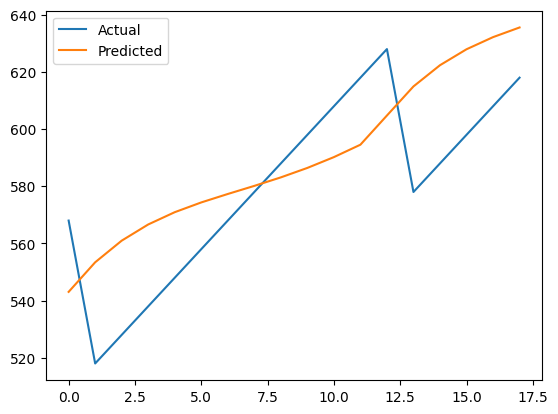

In [131]:
# probably it is better to use neural networks in place of Arima or any other linear regression
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data
df1 = pd.DataFrame({
    'sales': [100 + 3*x + 5*(x % 12) + 2*(x-1) for x in range(1, 101)]  # Example sales with trend and seasonality
})
print(df1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df1) #Data
print(df_scaled)

# Create sequences of 10 time steps for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(df_scaled, time_steps)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Inverse scaling to get the original values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

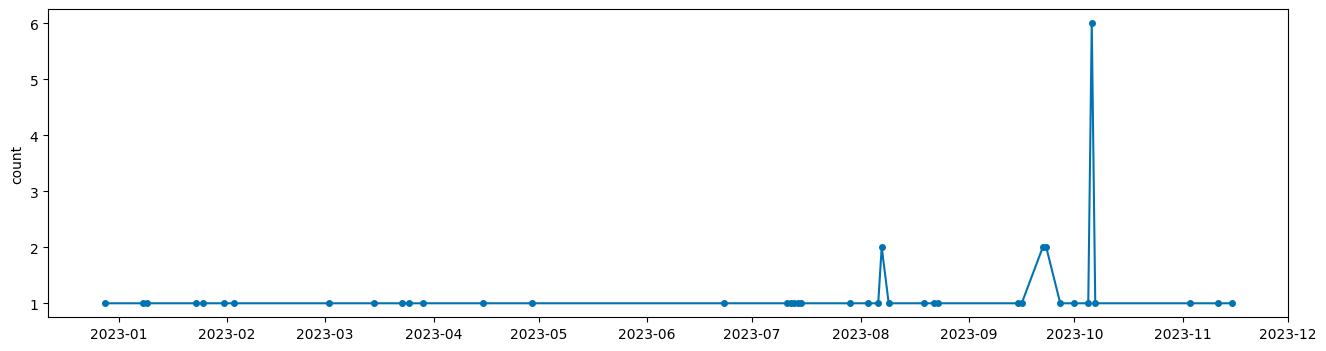

In [111]:
# On s'assure que la date est bien déclarée

Data['time'] = pd.to_datetime(Data['time'], format='%Y-%m-%d')

# On déclare la date en index (important pour sktime!)

Data_ts = Data.set_index('time')

# Pour cet exemple, on ne garde que les séries à partir de juin 2024 (trop de zéros avant).
# On doit aussi choisir la classification à prédire

Data_ts = Data_ts[(Data_ts['class']==9)]

# On ne garde que l'index et la série modélisée (important pour sktime!)

Data_ts = Data_ts.drop(['class'], axis=1)

# Déclarer la fréquence des données (important pour sktime!)

Data_ts.index = Data_ts.index.to_period("D")
plot_series(Data_ts)

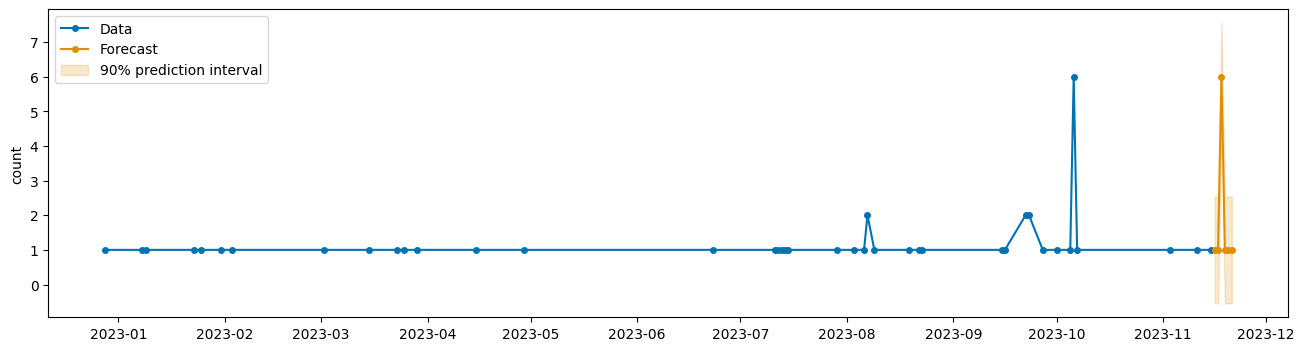

In [112]:
# 1) Définir l'horizon de prédiction

fh = np.arange(1, h_max) 

# 2) Choisir le modèle de forecasting

forecaster = AutoARIMA(sp = 7, suppress_warnings=True) 

# 3) Estimer le modèle sur les données d'entrainement

forecaster.fit(Data_ts, fh=fh)

# 4) Calculer la prévision

y_pred = forecaster.predict(fh=fh) # Point forecasts
y_pred_ints = forecaster.predict_interval(coverage=0.9) # Intervals
# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    Data_ts, y_pred, 
    labels=["Data", "Forecast"], 
    pred_interval=y_pred_ints
)

ax.legend();

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

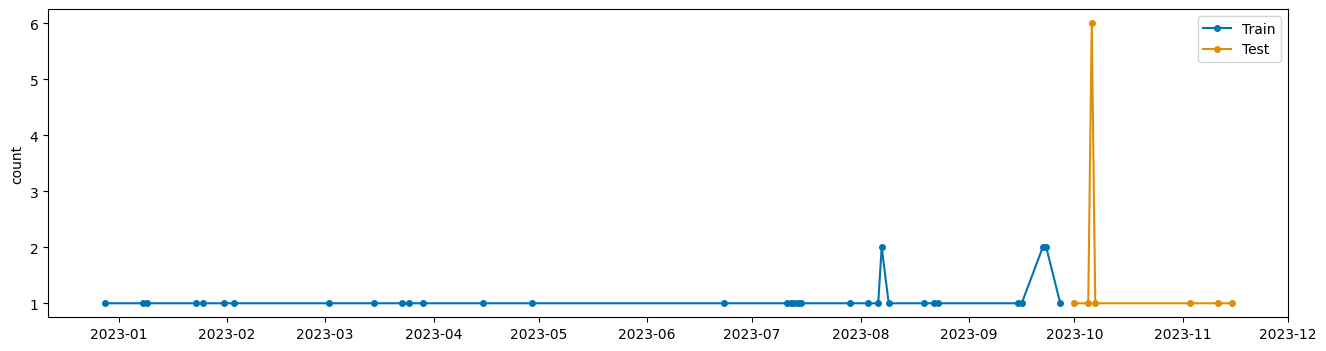

In [113]:
# Ici, on va garder une partie de la série sur laquelle on teste le modèle. 
# Le modèle est entrainé sur une fraction de la série (train set) et testé sur le reste (test set)

forecaster2 = AutoARIMA(sp = 7, suppress_warnings=True) 
y_train, y_test = temporal_train_test_split(Data_ts, test_size=h_backward) # On split le jeu de données
plot_series(y_train, y_test, labels=["Train", "Test"]) # On visualise

            count
2022-12-28      1
2023-01-08      1
2023-01-09      1
2023-01-23      1
2023-01-25      1
2023-01-31      1
2023-02-03      1
2023-03-02      1
2023-03-15      1
2023-03-23      1
2023-03-25      1
2023-03-29      1
2023-04-15      1
2023-04-29      1
2023-06-23      1
2023-07-11      1
2023-07-12      1
2023-07-13      1
2023-07-14      1
2023-07-15      1
2023-07-29      1
2023-08-03      1
2023-08-06      1
2023-08-07      2
2023-08-09      1
2023-08-19      1
2023-08-22      1
2023-08-23      1
2023-09-15      1
2023-09-16      1
2023-09-22      2
2023-09-23      2
2023-09-27      1
            count
2023-10-01      1
2023-10-05      1
2023-10-06      6
2023-10-07      1
2023-11-03      1
2023-11-11      1
2023-11-15      1


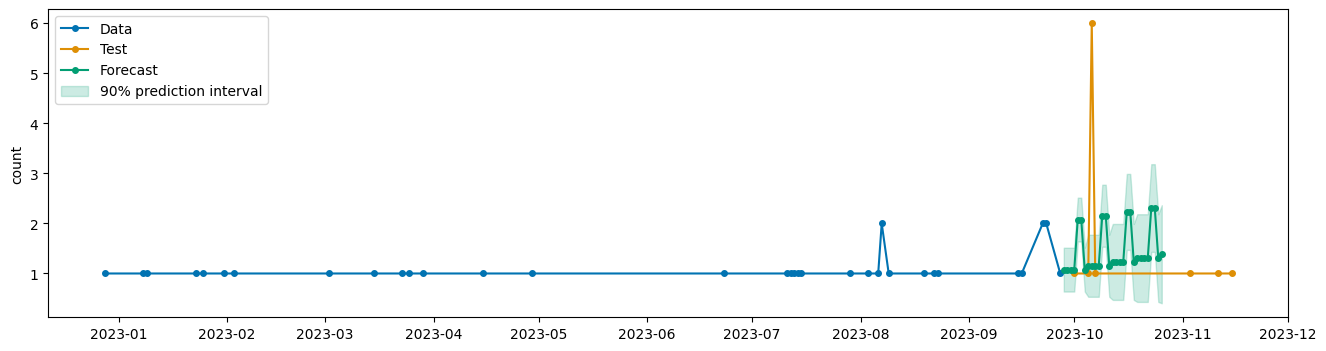

In [114]:
print(y_train)
print(y_test)
fh=np.arange(1, 30)
forecaster2.fit(y_train, fh=fh  )

# 4) Calculer la prévision

y_pred = forecaster2.predict(fh=fh) # Point forecasts
y_pred_ints = forecaster2.predict_interval(coverage=0.9) # Intervals

y_pred = forecaster2.predict()

fig, ax = plotting.plot_series(
    y_train, y_test, y_pred, 
    labels=["Data", "Test", "Forecast"], 
    pred_interval=y_pred_ints
)

ax.legend();

In [115]:
# Panel Forecasting

# Un des gros intérêts de sktime est de pouvoir entrainer des modèles sur un panel de séries temporelles en un coup.

# Dans notre cas, on va pouvoir entrainer des modèles sur les K thèmes de notre classification (10, 20, 50 ou plus)

Data_panel = Data.copy()
#Data_panel = Data_panel[Data_panel.time>'2024-06-15'] # On ne garde que la période sur laquelle on a des valeurs
Data_panel.set_index(['class', 'time'], inplace=True) # Double index
Data_panel.index = Data_panel.index.set_levels(
    [Data_panel.index.levels[0], pd.DatetimeIndex(Data_panel.index.levels[1]).to_period('D')]
)
Data_panel # Output

count
class time             
0     2022-12-11      1
      2022-12-13      1
      2022-12-15      1
      2022-12-30      1
      2023-01-05      2
...                 ...
17    2023-06-20      2
      2023-07-11      1
      2023-08-16      1
      2023-09-20      1
      2023-09-22      1

[584 rows x 1 columns]

In [122]:
print(Data_panel.isnull().sum())
print(Data_panel.describe())
Data_panel = Data_panel.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill
print(Data_panel.isnull().sum())
print(Data_panel.describe())

count    0
dtype: int64
            count
count  584.000000
mean     1.712329
std      2.568336
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     42.000000
count    0
dtype: int64
            count
count  584.000000
mean     1.712329
std      2.568336
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     42.000000


In [123]:
# entrainer des modèles sur chaque hierarchie

fh = np.arange(1, h_max) 

# Modèle AutoARIMA
forecaster = AutoARIMA(sp = 7, seasonal=False, suppress_warnings=True) 

# Prédiction
y_pred = forecaster.fit(Data_panel, fh=fh).predict() #Point forecasts
y_pred_ints = forecaster.predict_interval(coverage=0.9) # Intervals

/home/taoufik/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/taoufik/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/taoufik/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/taoufik/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/taoufik/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.war

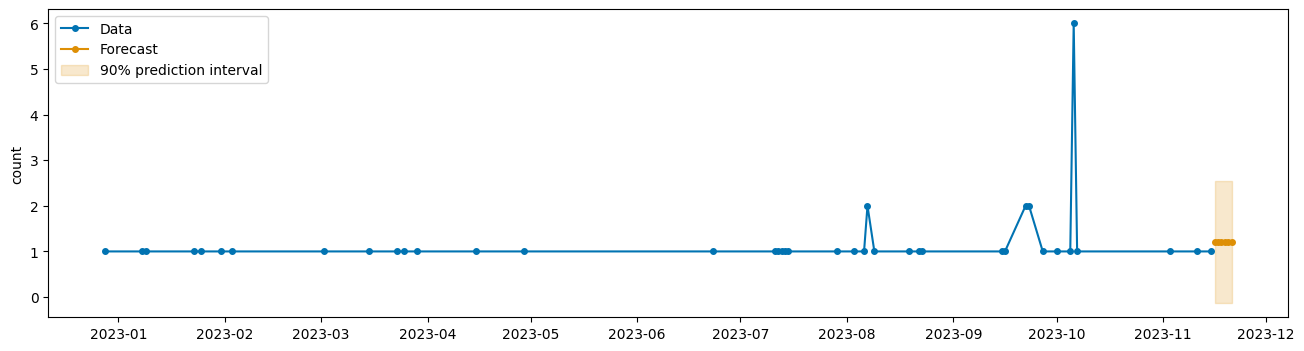

In [124]:
# On peut représenter les forecast un-à-un en selectionnant une partie du tableau avec .xs

class_to_plot = 9 # On choisit la catégorie à afficher

fig, ax = plotting.plot_series(
    Data_panel.xs(class_to_plot, level='class'), y_pred.xs(class_to_plot, level='class'), 
    labels=["Data", "Forecast"],
    pred_interval=y_pred_ints.xs(class_to_plot, level='class')
)
ax.legend();

In [ ]:
# Train-Test Split sur du Panel

# Ici, on va entrainer un modèle sur toutes les classes k20 et on va prédire une partie des données observées

y_train, y_test = temporal_train_test_split(Data_panel, test_size=h_backward) #On découpe le jeu entre train et test

fh = np.arange(1, h_backward+1) # Forecasting Horizon

forecaster = AutoETS(error = "add", trend = "add", seasonal = "add", sp=7)   # Modèle

# Prédiction
y_pred = forecaster.fit(y_train, fh=fh).predict() # Point forecasts
y_pred_ints = forecaster.predict_interval(coverage=0.9) # Intervals

In [ ]:
class_to_plot = 4 # On choisit la catégorie à afficher

fig, ax = plotting.plot_series(
    y_train.xs(class_to_plot, level='class'), y_test.xs(class_to_plot, level='class'), y_pred.xs(class_to_plot, level='class'),
    labels=["Data", "Test (réel)", "Forecast"],
    pred_interval=y_pred_ints.xs(class_to_plot, level='class')
)
ax.legend();

In [ ]:
# TODO generate forecasts

In [ ]:
spark.sql(f"""
    DELETE FROM comp_content_time_series
    WHERE project_id='{context["project_id"]}' AND
          content_group='{context["import_id"]}'
""")

topics = reduce(DataFrame.unionAll, [summary for content_cluster, summary in summaries.items()])

topics.writeTo(f"""comp_content_time_series""").using("delta").append()

display(topics)